## Unbalanced Dataset (Full + NDVI)

Here we calculate errors with various classical methods: 

Data: Sentinel-1 + Sentinel-2 + Engineered RGB features from Sentinel-2 + extra NDVI 



In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
data = np.load('pixels_features_shuffled.npy')

# load the numpy array into a pandas dataframe
df = pd.DataFrame(data)

df.head()
df.describe()

# extract the last column as a numpy array
y = df.iloc[:, -1].values
print('Here is the shape of y', y.shape)

# extract all other columns as a numpy array
X = df.iloc[:, :-1].values


# print the shape of the new X array
print('Here is the shape of X:', X.shape)

Here is the shape of y (648206,)
Here is the shape of X: (648206, 23)


In [3]:
# Define the positions of the red and near-infrared bands in the array
red_band_index = 2
nir_band_index = 6

# Extract the red and near-infrared bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]

# Calculate NDVI and normalize
ndvi = np.zeros_like(nir_band)
mask = (nir_band + red_band) != 0
ndvi[mask] = (nir_band[mask] - red_band[mask]) / (nir_band[mask] + red_band[mask])
ndvi = np.clip(ndvi, -1, 1) # clip values outside [-1, 1] range
ndvi = (ndvi + 1) / 2 # rescale to [0, 1] range

# Add the NDVI feature to the array
X_with_ndvi = np.insert(X, -1, ndvi, axis=1)

X=X_with_ndvi 

print(X.shape)

(648206, 24)


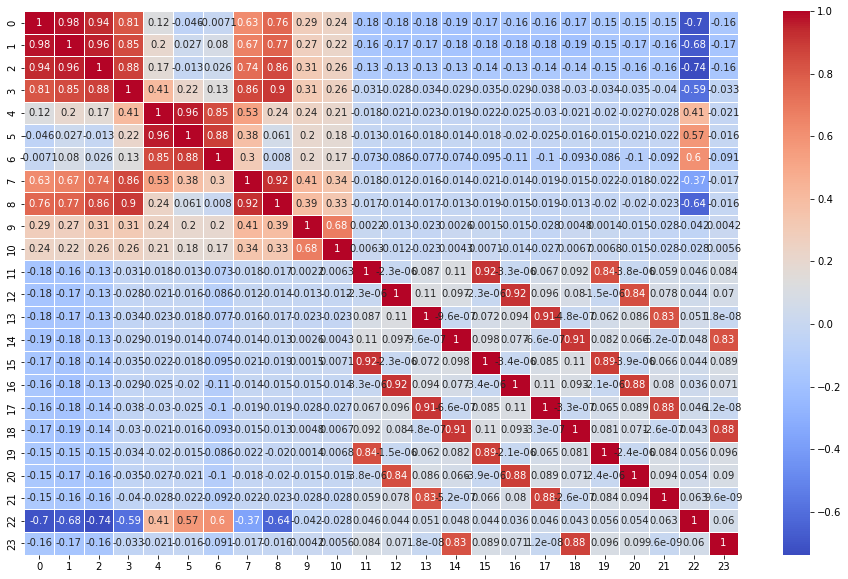

In [4]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(16, 10))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()

In [5]:
##### Runs various models on X and y prepared above 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_lr)))
print()

print("Decision Tree:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_dt)))
print()

print("Random Forest:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
print()

print("Gradient Boosting:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_gb)))
print()


Linear Regression:
Mean Squared Error: 22.16
R-squared: 0.10

Decision Tree:
Mean Squared Error: 47.64
R-squared: -0.93

Random Forest:
Mean Squared Error: 21.89
R-squared: 0.11

Gradient Boosting:
Mean Squared Error: 21.76
R-squared: 0.12



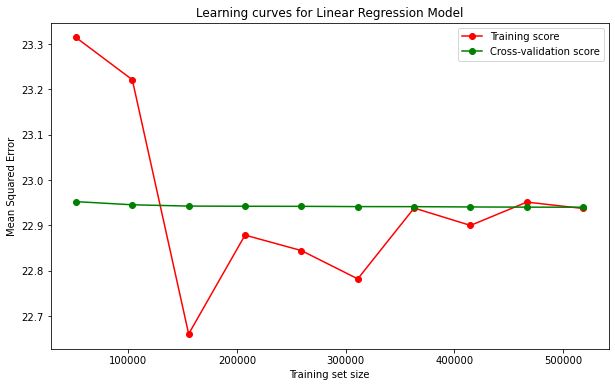

In [6]:
### Learning Curve for the regression model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

# Create an instance of the Linear Regression model
lr_model = LinearRegression()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Linear Regression model
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Linear Regression Model')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()


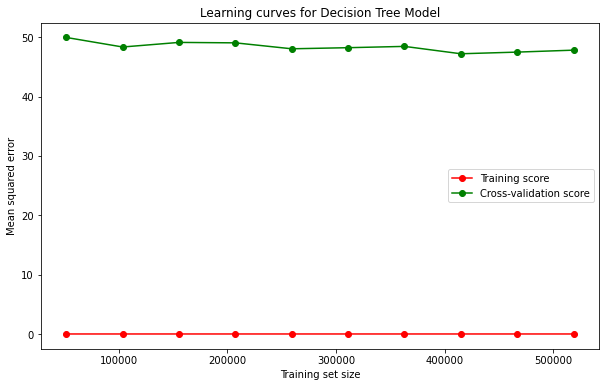

In [7]:
# Learning curve for the Decision Tree model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve

# Convert y to a 1d array using ravel()
y = np.ravel(y)

# Create an instance of the Decision Tree model
tree_model = DecisionTreeRegressor()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Decision Tree model
train_sizes, train_scores, test_scores = learning_curve(tree_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Decision Tree Model')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()


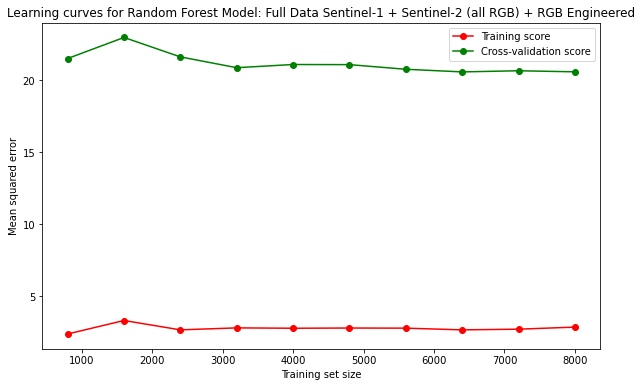

In [8]:
#### LESS DATA IN INPUT !!! 300000 rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples
subset_idx = np.random.choice(len(X), size=10000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Full Data Sentinel-1 + Sentinel-2 (all RGB) + RGB Engineered')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

In [9]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "R-squared:", r2)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   1.3s
[CV] END .....................................normalize=True; total time=   1.1s
[CV] END .....................................normalize=True; total time=   1.1s
[CV] END .....................................normalize=True; total time=   1.1s
[CV] END .....................................normalize=True; total time=   1.1s
[CV] END ....................................normalize=False; total time=   1.0s
[CV] END ....................................normalize=False; total time=   1.0s
[CV] END ....................................normalize=False; total time=   1.1s
[CV] END ....................................normalize=False; total time=   1.0s
[CV] END ....................................normalize=False; total time=   1.0s
LinearRegression best hyperparameters: {'normalize': True} MSE: 22.15699160066904 R-squared: 0.10036609289170328
Fitting 5 folds f

Random Forest (max_depth=15, n_estimators=300):
Mean Squared Error: 21.64
R-squared: 0.12



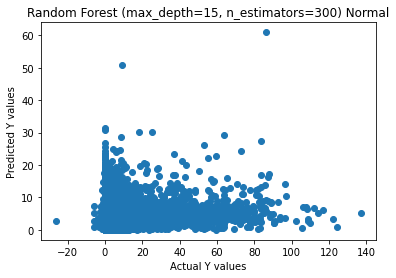

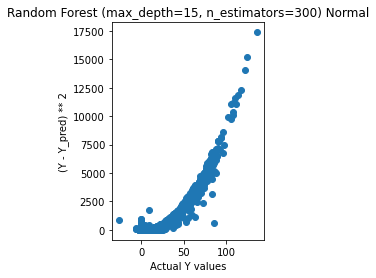

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Scale X using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Train the Random Forest Regressor model on the training data
rf = RandomForestRegressor(max_depth=15, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf.predict(X_test)

# Evaluate the Random Forest Regressor model using mean squared error and R-squared
print("Random Forest (max_depth=15, n_estimators=300):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
print()

# Plot predicted values vs actual values for RandomForestRegressor
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Y values')
plt.ylabel('Predicted Y values')
plt.title('Random Forest (max_depth=15, n_estimators=300) Normal')
plt.show()

# Plot (Y - Y_pred) ** 2 versus Y
plt.subplot(1, 2, 2)
plt.scatter(y_test, (y_test - y_pred_rf) ** 2)
plt.xlabel('Actual Y values')
plt.ylabel('(Y - Y_pred) ** 2')
plt.title('Random Forest (max_depth=15, n_estimators=300) Normal')
plt.show()

In [10]:
#### Import 

import numpy as np

# Define the positions of the red, near-infrared, blue, red-edge, and SWIR bands in the array
red_band_index = 2
nir_band_index = 6
blue_band_index = 0
rededge_band_index = 4
swir1_band_index = 7
swir2_band_index = 8

# Extract the bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
blue_band = X[:, blue_band_index]
rededge_band = X[:, rededge_band_index]
swir1_band = X[:, swir1_band_index]
swir2_band = X[:, swir2_band_index]

# Calculate NDVI and normalize
ndvi = np.zeros_like(nir_band)
mask = (nir_band + red_band) != 0
ndvi[mask] = (nir_band[mask] - red_band[mask]) / (nir_band[mask] + red_band[mask])
ndvi = np.clip(ndvi, -1, 1) # clip values outside [-1, 1] range
ndvi = (ndvi + 1) / 2 # rescale to [0, 1] range

# Create a mask for vegetation pixels
vegetation_mask = ndvi > 0.3

# Create a mask for rock pixels
rock_mask = (swir1_band > 0.15) & ~vegetation_mask

# Create a mask for building pixels
building_mask = (blue_band > 0.2) & (rededge_band > 0.25) & (swir1_band < 0.15) & (swir2_band < 0.1) & ~vegetation_mask & ~rock_mask

# Create a mask for soil pixels
soil_mask = ~(vegetation_mask | rock_mask | building_mask)


# Count the number of pixels with vegetation, rock, building, and soil values
vegetation_pixels = np.count_nonzero(vegetation_mask)
rock_pixels = np.count_nonzero(rock_mask)
building_pixels = np.count_nonzero(building_mask)
soil_pixels = np.count_nonzero(soil_mask)
total_pixels = ndvi.size

# Calculate the fraction of vegetation, rock, building, and soil pixels
fraction_vegetation = vegetation_pixels / total_pixels
fraction_rock = rock_pixels / total_pixels
fraction_building = building_pixels / total_pixels
fraction_soil = soil_pixels / total_pixels

print(f"Fraction of vegetation pixels: {fraction_vegetation:.2f}")
print(f"Fraction of rock pixels: {fraction_rock:.2f}")
print(f"Fraction of building pixels: {fraction_building:.2f}")
print(f"Fraction of soil pixels: {fraction_soil:.2f}")


Fraction of vegetation pixels: 0.52
Fraction of rock pixels: 0.24
Fraction of building pixels: 0.00
Fraction of soil pixels: 0.24
